In [1]:
import pandas as pd, geopandas as gpd, matplotlib.pyplot as plt, seaborn as sns, matplotlib.ticker as ticker, matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set(style="whitegrid", font_scale=1.5)

data = gpd.read_file("houses_current.geojson")
data = data[data.block_size < 2500]

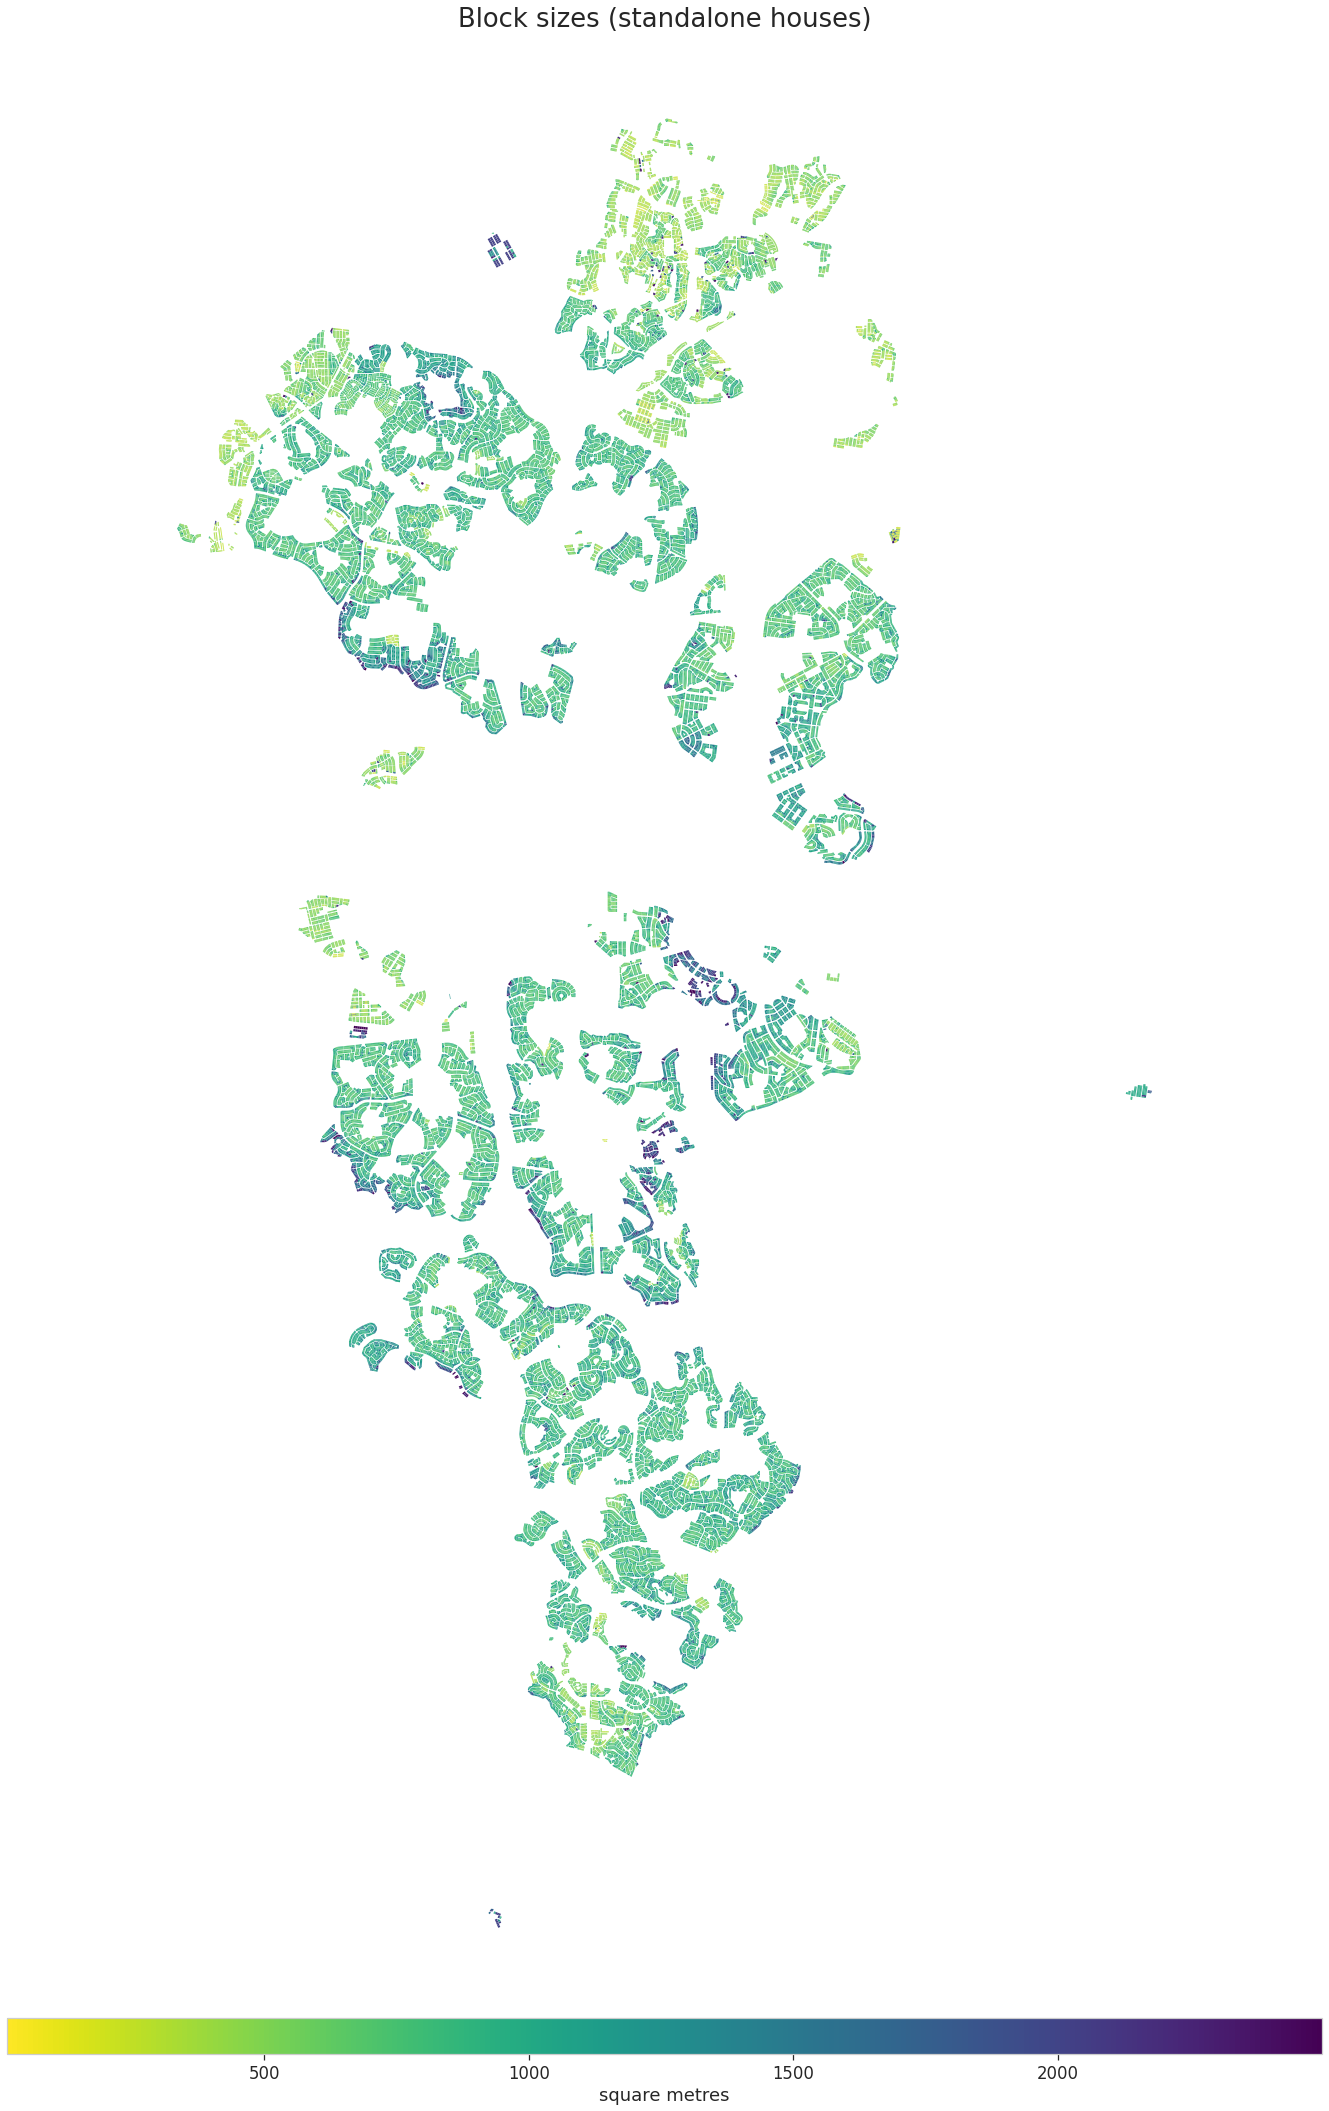

In [2]:
fig, ax = plt.subplots(
    1,1,
    tight_layout=True,
    figsize=(20, 30)
)
divider = make_axes_locatable(ax)
cax = divider.append_axes(position="bottom", size=.5, pad=0)

data.plot(
    column="block_size",
    ax=ax,
    cax=cax,
    linewidth=0, 
    cmap="viridis_r",
    legend=True,
    legend_kwds={
        "label": "square metres",
        "orientation": "horizontal"
    }
)
ax.set_axis_off()
plt.suptitle("Block sizes (standalone houses)", fontsize="x-large")
plt.savefig("block_sizes.jpg")
plt.show()

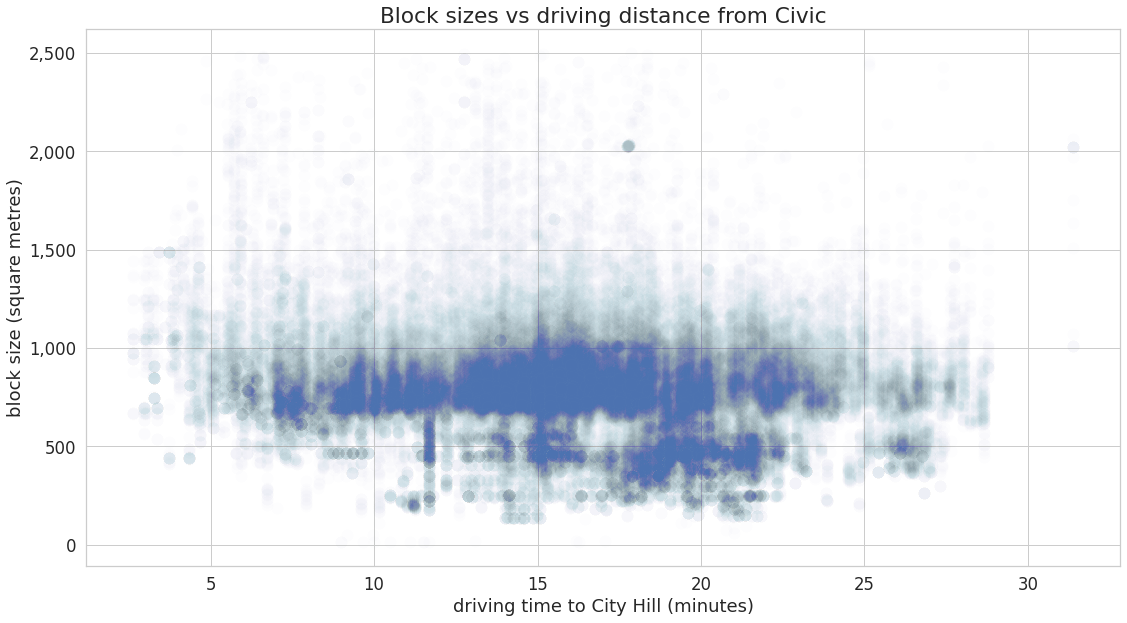

In [109]:
fig, ax = plt.subplots(
    tight_layout=True,
    figsize=(16, 9)
)

sns.scatterplot(data=data, ax=ax, x=data.time / 60, y="block_size", s=150, alpha=.0075)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))
plt.xlabel("driving time to City Hill (minutes)")
plt.ylabel("block size (square metres)")
plt.title("Block sizes vs driving distance from Civic", fontsize="large")
plt.savefig("commute_times.jpg")

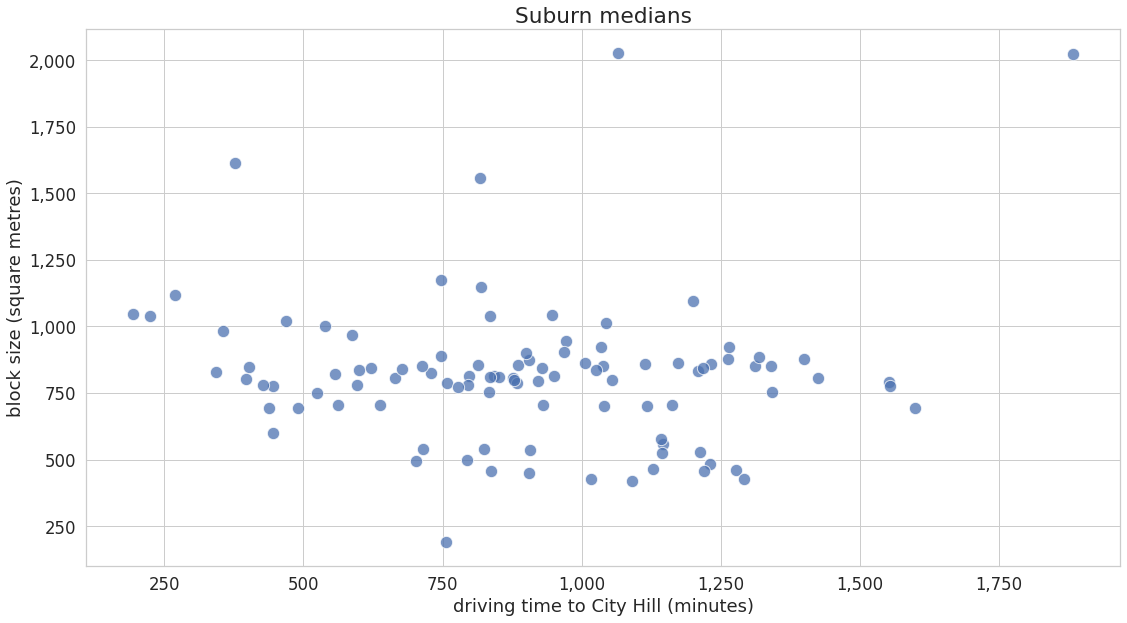

In [117]:
agg = data.groupby("division").agg({"block_size":"median","time":"median"})

fig, ax = plt.subplots(
    tight_layout=True,
    figsize=(16, 9)
)

sns.scatterplot(data=agg, ax=ax, x="time", y="block_size", s=150, alpha=.75)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))
plt.xlabel("driving time to City Hill (minutes)")
plt.ylabel("block size (square metres)")
plt.title("Suburn medians", fontsize="large")
plt.savefig("suburb_commute_times.jpg")

In [111]:
def parse_string(string):
    string = string.split(" ")
    hot = float(string[-1])
    canopy = float(string[-2])
    if string[0] in ["Woden", "Canberra", "Molonglo", "Weston", "Paddys"]:
        district = " ".join(string[:2])
        suburb = " ".join(string[2:-2])
    else:
        district = string[0]
        suburb = " ".join(string[1:-2])
    return [suburb, canopy, hot]    

raw_text = pd.read_csv("trees.txt", header=None, names=["string"])
df = pd.DataFrame(columns=["suburb", "canopy", "heat"])

for i in raw_text.index:
    df.loc[i] = parse_string(raw_text.at[i, "string"])

df.set_index("suburb", inplace=True)

def parse_suburb(string):
    string = string.split(" ")
    if string[0].isupper():
        date_index = [x.isnumeric() for x in string].index(True)
        suburb = " ".join([x[0].upper() + x[1:].lower() for x in string[:date_index]])
        if ("'" in suburb) | (suburb[:2] == "Mc"):
            suburb = suburb[:2] + suburb[2].upper() + suburb[3:]
        date = pd.Timestamp(f"{' '.join(string[date_index:date_index + 3])}")
        df.at[suburb, "gazetted"] = date

raw_text = pd.read_csv("suburbs.txt", header=None, names=["string"])

for i in raw_text.index:
    parse_suburb(raw_text.at[i, "string"])
    
df.dropna(inplace=True)
df.index = [suburb.upper() for suburb in df.index]
df

canopy   heat   gazetted
ISAACS             44.87   0.00 1966-05-12
O'CONNOR           44.23   0.62 1928-09-20
RED HILL           40.67   1.90 1928-09-20
REID               40.53   0.00 1928-09-20
HACKETT            39.81   0.87 1960-04-07
...                  ...    ...        ...
CANBERRA AIRPORT    3.72  64.00 2014-01-01
MACNAMARA           3.41   0.00 2016-06-25
WRIGHT              2.63  40.20 2011-05-17
WHITLAM             2.43   0.00 2019-11-13
THROSBY             2.37   0.00 1966-05-12

[120 rows x 3 columns]

In [118]:
for suburb in agg.index:
    agg.at[suburb, "gazetted"] = df.at[suburb.upper(), "gazetted"]
agg

block_size    time   gazetted
division                                 
AINSLIE          848.0   403.0 1928-09-20
AMAROO           559.0  1146.7 1991-10-18
ARANDA           821.5   556.5 1967-06-22
BANKS            694.0  1599.1 1987-03-12
BARTON           984.0   354.8 1956-05-24
...                ...     ...        ...
WEETANGERA      1175.0   747.4 1968-08-22
WESTON           773.0   777.0 1970-07-02
WHITLAM          495.0   701.7 2019-11-13
WRIGHT           500.0   793.2 2011-05-17
YARRALUMLA       780.0   426.6 1928-09-20

[101 rows x 3 columns]

In [125]:
for suburb in agg.index:
    i = data.division.tolist().index(suburb)
    agg.at[suburb, "district"] = data.district.tolist()[i]
agg

block_size    time   gazetted          district
division                                                   
AINSLIE          848.0   403.0 1928-09-20  CANBERRA CENTRAL
AMAROO           559.0  1146.7 1991-10-18         GUNGAHLIN
ARANDA           821.5   556.5 1967-06-22         BELCONNEN
BANKS            694.0  1599.1 1987-03-12       TUGGERANONG
BARTON           984.0   354.8 1956-05-24  CANBERRA CENTRAL
...                ...     ...        ...               ...
WEETANGERA      1175.0   747.4 1968-08-22         BELCONNEN
WESTON           773.0   777.0 1970-07-02      WESTON CREEK
WHITLAM          495.0   701.7 2019-11-13   MOLONGLO VALLEY
WRIGHT           500.0   793.2 2011-05-17   MOLONGLO VALLEY
YARRALUMLA       780.0   426.6 1928-09-20  CANBERRA CENTRAL

[101 rows x 4 columns]

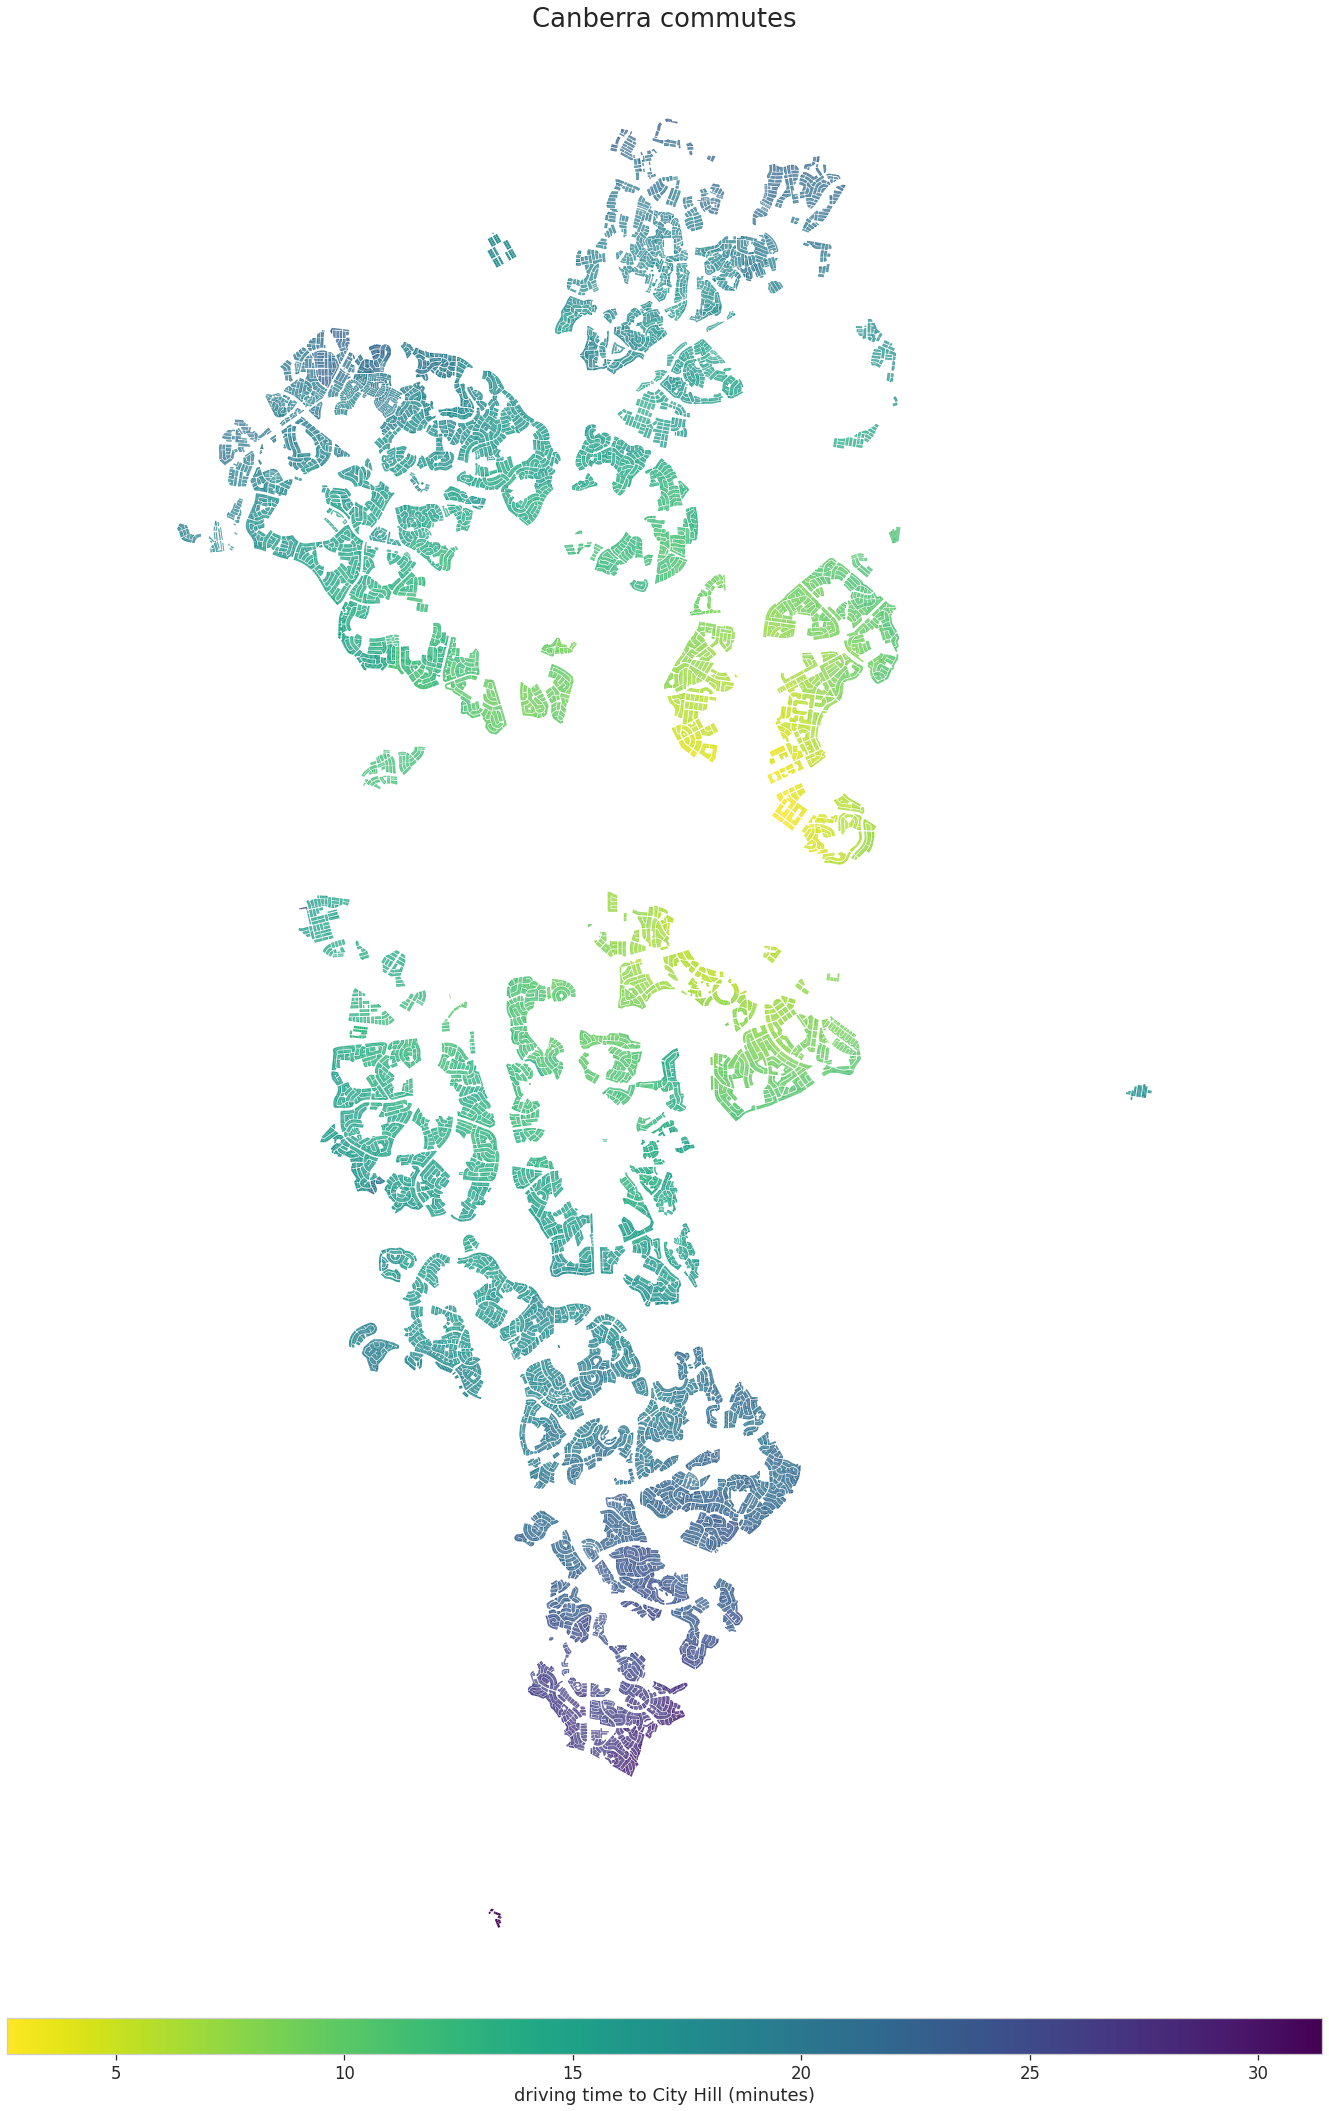

In [157]:
fig, ax = plt.subplots(
    1,1,
    tight_layout=True,
    figsize=(20, 30)
)
divider = make_axes_locatable(ax)
cax = divider.append_axes(position="bottom", size=.5, pad=0)

data.plot(
    column=data.time / 60,
    ax=ax,
    cax=cax,
    linewidth=0, 
    cmap="viridis_r",
    legend=True,
    legend_kwds={
        "label": "driving time to City Hill (minutes)",
        "orientation": "horizontal"
    }
)
ax.set_axis_off()
plt.suptitle("Canberra commutes", fontsize="x-large")
plt.savefig("commute_distances.jpg")
plt.show()

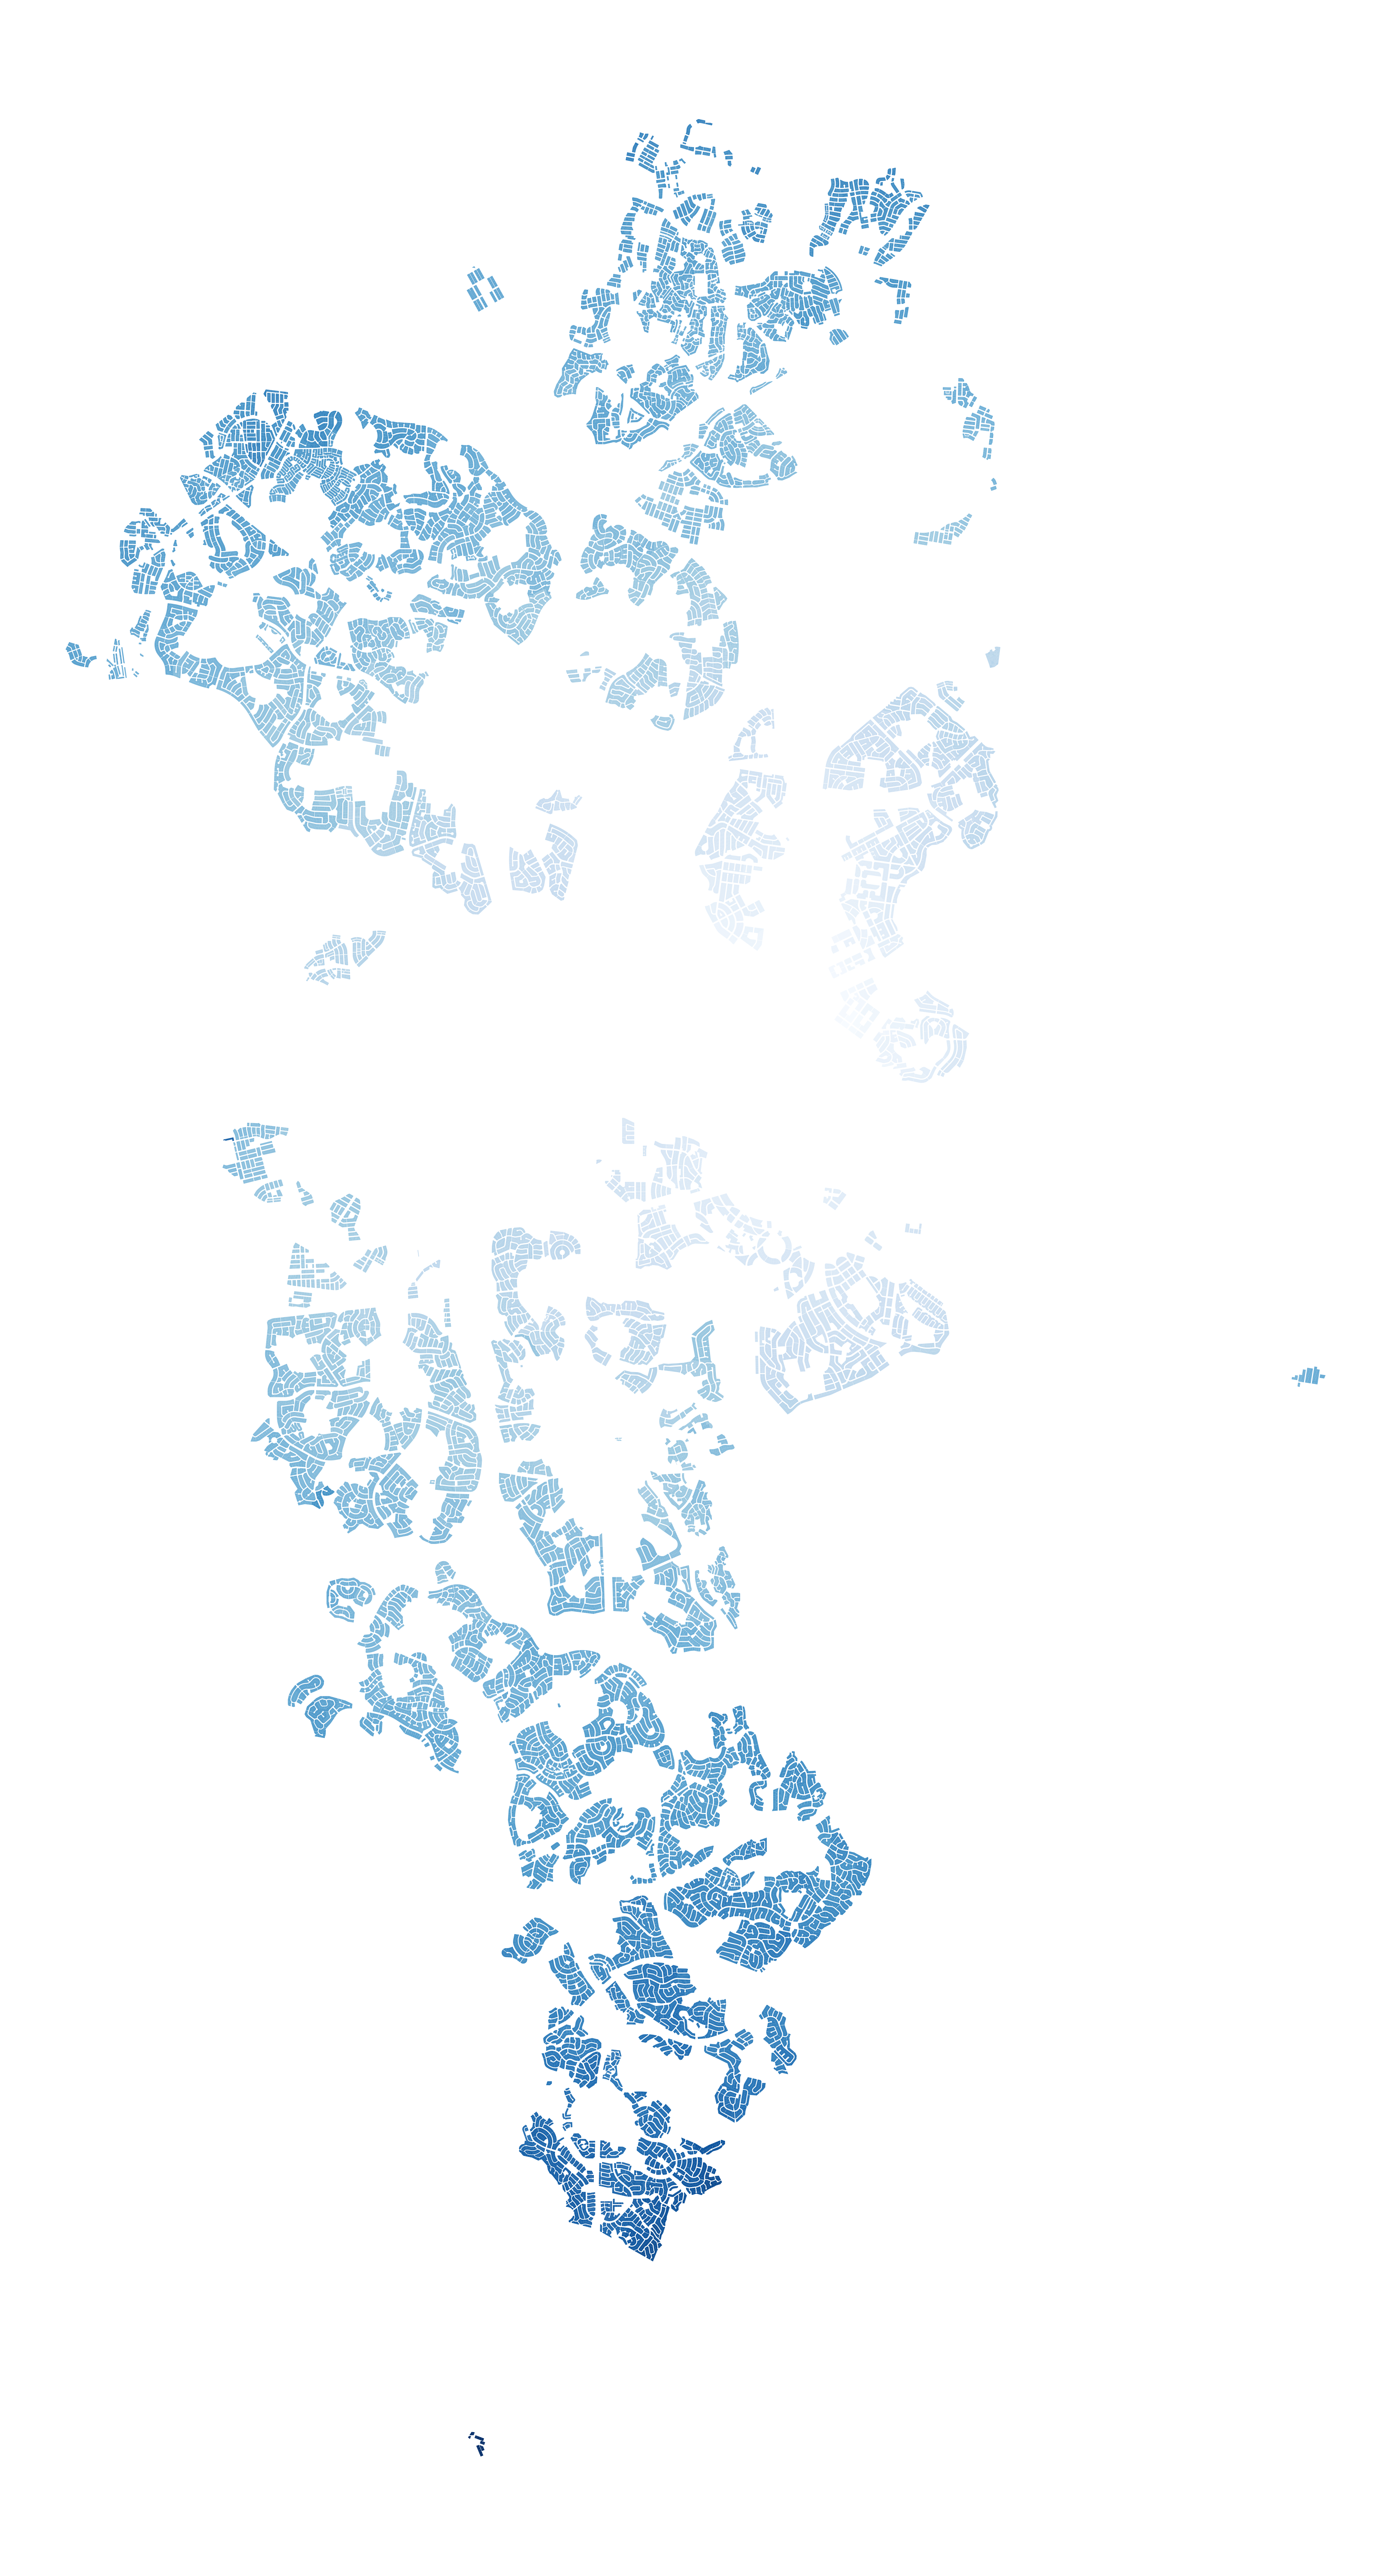

In [71]:
fig, ax = plt.subplots(
    tight_layout=True,
    figsize=(100, 100)
)

data.plot("time", cmap="Blues", ax=ax, linewidth=0)
ax.set_axis_off()
plt.savefig("commute_times.jpg")
plt.show()

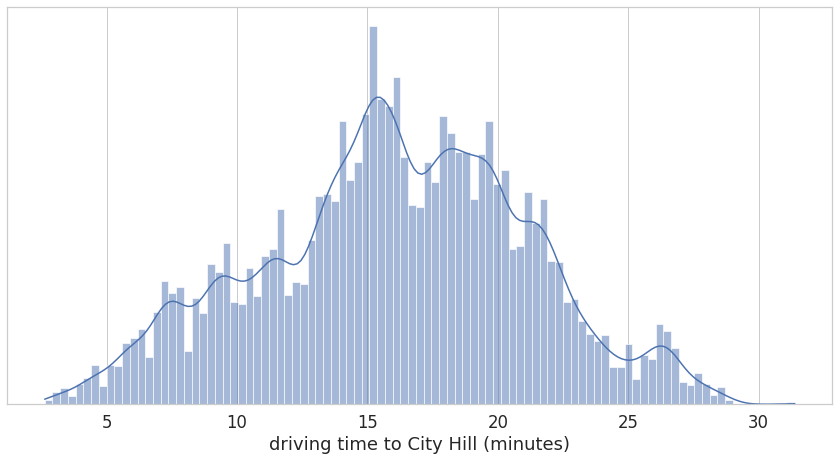

In [146]:
fig, ax = plt.subplots(
    tight_layout=True,
    figsize=(12, 6.75)
)

sns.histplot(data=data, ax=ax, x=data.time / 60, kde=True)
plt.xlabel("driving time to City Hill (minutes)")
plt.ylabel(None)
ax.yaxis.set_visible(False)
plt.savefig("driving_histo.jpg")

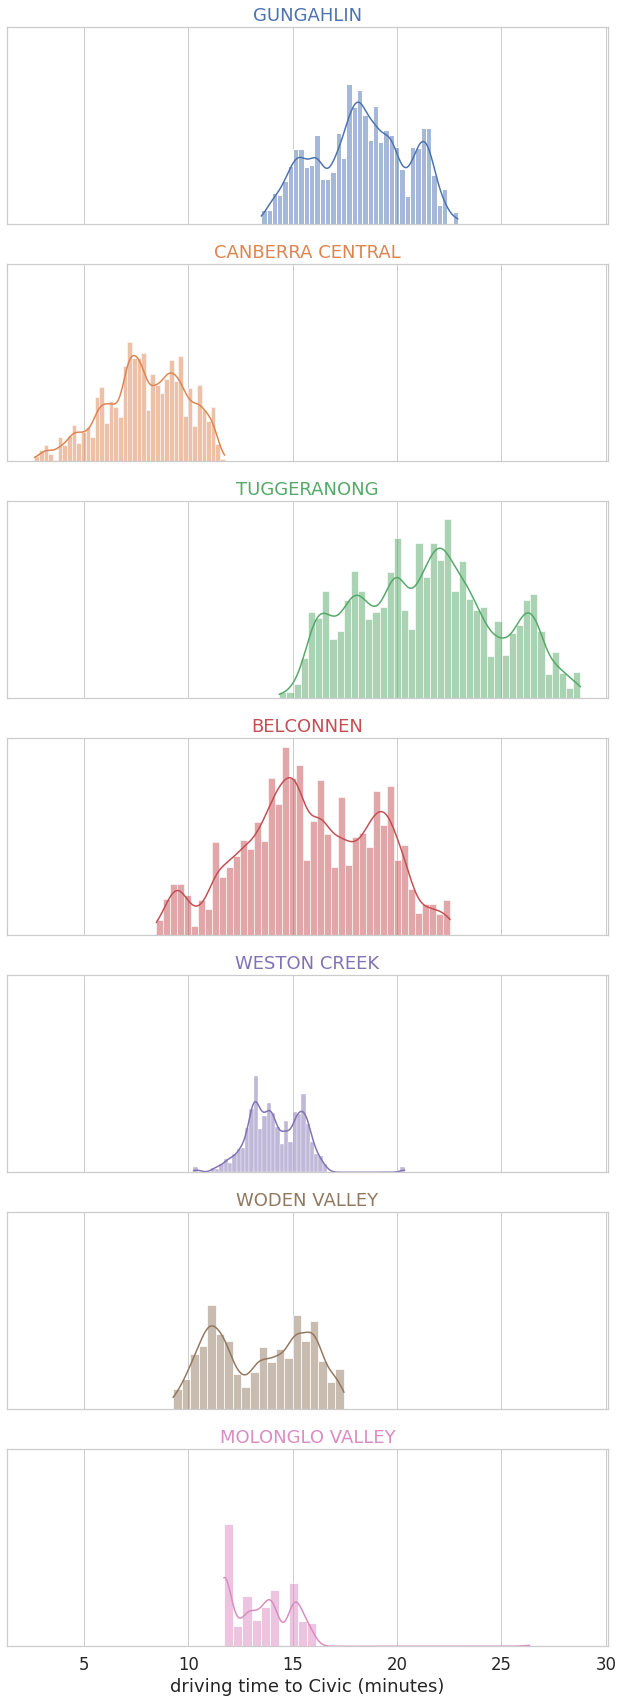

In [202]:
fig, ax = plt.subplots(
    7, 1,
    tight_layout=True,
    figsize=(9, 24),
    sharex=True,
    sharey=True
)

for i, district in enumerate(['GUNGAHLIN', 'CANBERRA CENTRAL', 'TUGGERANONG', 'BELCONNEN', 'WESTON CREEK', 'WODEN VALLEY', 'MOLONGLO VALLEY']):
    chart_data = data[data.district == district][["district", "time"]]    
    sns.histplot(data=chart_data, ax=ax[i], x=chart_data.time / 60, kde=True, color=sns.color_palette()[i])
    ax[i].yaxis.set_visible(False)
    ax[i].set_title(district, color=sns.color_palette()[i])

plt.xlabel("driving time to Civic (minutes)")
plt.savefig("district_histos.jpg")

